# Building a Sequential Multi-Agent Travel Assistant with LangGraph

## Table of Contents
- [Introduction](#introduction)
- [Prerequisites](#prerequisites)
- [Setup](#setup)
- [Create Your First Agent](#create-your-first-agent)
- [Add More Agents](#add-more-agents)
- [Enhance Agent Capabilities Using Tools](#enhance-agent-capabilities-using-tools)

## Introduction

**LangGraph** is an extension of LangChain that provides a framework for building stateful, multi-agent applications. This notebook demonstrates how to create a travel assistant using multi-agent collaboration with LangGraph. Specifically, you will use this assistant to generate articles on the top activities and attractions for a specific location.

**Estimated completion time:** 30-45 minutes

### Objectives

By the end of this notebook, you will:
1. Understand how to create and connect multiple agents in a sequential workflow
2. Learn how to define agent roles and responsibilities
3. Implement a multi-agent system that can research, write, and edit travel content
4. Enhance agent capabilities by integrating external tools

### Structure of the Travel Assistant

This notebook provides step-by-step guidance for creating a travel assistant consisting of the following agents:

```mermaid
graph LR
    User[User Query] --> A[Researcher Agent]
    A --> B[Content Writer Agent]
    B --> C[Editor Agent]
    C --> D[Final Article]
    
    style A fill:#f9d5e5,stroke:#333,stroke-width:2px
    style B fill:#eeac99,stroke:#333,stroke-width:2px
    style C fill:#e06377,stroke:#333,stroke-width:2px
    style D fill:#c83349,stroke:#333,stroke-width:2px
```

1. **Researcher Agent** - Responsible for gathering information on the top 5 attractions and activities in a specific location
2. **Content Writer Agent** - Responsible for writing an engaging article based on the information of the top 5 attractions
3. **Editor Agent** - Responsible for improving the flow and language use within the article

## Prerequisites

Before starting this notebook, ensure you have:
- Basic understanding of Python and Jupyter notebooks
- AWS account with access to Amazon Bedrock and SageMaker
- Tavily API key (for web search functionality)
- Familiarity with LangChain concepts (optional but helpful)

---

## Setup

Start by installing some of the required packages, including LangChain for pre-built tool components, LangGraph for agent workflows, and other necessary libraries.

In [ ]:
%pip install -r langgraph-requirements.txt -qU

<div class="alert alert-block alert-info">
<b>Important:</b> restart the kernel before proceeding with the next cells.
</div>

In [1]:
from langchain_aws import ChatBedrock, SagemakerEndpoint
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command
import boto3
import os
import getpass
import json
from textwrap import dedent
from typing import Literal

Now import all of the packages you will need for this lab. This includes the packages described above, as well as textwrap for keeping the prompts readable within the notebook, and typing for type annotations.

Follow the instructions in [this lab](https://catalog.workshops.aws/building-agentic-workflows/en-US/sagemaker) to create a SageMaker real-time endpoint hosting the [DeepSeek R1 Distill-Llama 8B](https://huggingface.co/deepseek-ai/DeepSeek-R1) model. Although you will use this specific model for this lab, LangGraph also supports other models hosted through [Amazon SageMaker](https://docs.crewai.com/concepts/llms#amazon-sagemaker) or [Amazon Bedrock](https://docs.crewai.com/concepts/llms#aws-bedrock). While the SageMaker endpoint is being created, you can copy the name of the endpoint and replace the text `INSERT ENDPOINT NAME` in the code below with the endpoint name.

When setting up an LLM model, you can also set model parameters. In this case, we set `temperature` to 0.7 to balance creativity with accuracy. A higher temperature (closer to 1.0) would produce more creative but potentially less accurate responses, while a lower temperature (closer to 0) would produce more deterministic responses.

In [2]:
model = ChatBedrock(
    model="us.amazon.nova-pro-v1:0",
    temperature=0.7,
    region="us-west-2"
)

If you want to use Amazon SageMaker AI endpoints, you can uncomment the following section:

In [3]:
from langchain_aws.llms.sagemaker_endpoint import LLMContentHandler
from typing import Dict

class ContentHandler(LLMContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, prompt: str, model_kwargs: Dict) -> bytes:
        input_str = json.dumps({"inputs": prompt, "parameters": model_kwargs})
        return input_str.encode("utf-8")

    def transform_output(self, output: bytes) -> str:
        response_json = json.loads(output.read().decode("utf-8"))
        return response_json[0]["generated_text"]


# model = SagemakerEndpoint(
#     endpoint_name="INSERT-ENDPOINT-NAME",
#     inference_component_name="INSERT-INFERENCE-COMPONENT-NAME",
#     region_name="us-west-2",
#     credentials_profile_name="default",
#     content_handler=ContentHandler()
# )

-----

## Create Your First Agent

Let's start by creating the first agent - the researcher agent. This agent will be responsible for gathering information on the top 5 attractions and activities for a specific location. 

> **Note:** We'll start simple by creating an agent which relies on the LLM's internal knowledge of various locations around the world. At a later stage, this agent can be extended by providing access to a web search tool.

### Understanding Agent Creation in LangGraph

In LangGraph, agents are created using the `create_react_agent` function, which implements the ReAct (Reasoning and Acting) pattern. This pattern allows the agent to reason about its actions and then execute them in an iterative process.

In [4]:
# Define the Agent
research_agent = create_react_agent(
    model=model,
    tools=[],
    prompt=dedent(
            """You are an experienced travel researcher with a knack for 
            discovering both popular attractions and hidden gems in any 
            location. Your expertise lies in gathering comprehensive 
            information about various activities, their historical 
            significance, and practical details for visitors. Research and 
            compile a list of at least 5 interesting activities and 
            attractions in the requested location. Include a mix of popular tourist 
            spots and lesser-known local favorites. For each item, provide:
            1. Name of the attraction/activity
            2. Brief description (2-3 sentences)
            3. Why it's worth visiting
            Your final answer should be a structured list of these items.
            """
    ),
)

### Creating a Node in the Workflow

Next, you will create a task. A task is defined in a **Node** object. In LangGraph, a Node represents a processing step in your workflow. Each node takes the current state as input, performs some operation, and returns a Command object that specifies how to update the state and where to go next in the workflow.

In [5]:
# Define the Node (task)
def research_node(state: MessagesState):
    result = research_agent.invoke(state)
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto="content_writer",
    )

### Creating Your First Graph

Now you can create your first graph. In LangGraph, a **StateGraph** represents the entire workflow, with nodes connected by edges that define the flow of execution.

In [6]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)

workflow.add_edge(START, "researcher")
# workflow.add_edge("researcher", END)
graph = workflow.compile()

### Testing Your First Agent

Now you can test your first agent! Since the current version of the researcher agent relies on the LLM's internal knowledge, choose a well-known location such as Amsterdam. The model has likely learned about Amsterdam in its training data.

**Expected Output:**
You should see the agent's thought process and a structured list of 5 attractions in Amsterdam, including names, descriptions, and reasons to visit each one.

In [7]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "Write a listicle for Amsterdam, Netherlands."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'researcher': {'messages': [HumanMessage(content='Write a listicle for Amsterdam, Netherlands.', additional_kwargs={}, response_metadata={}, id='6ed29c42-5b09-4321-8d4c-d0a01d15d3e7'), AIMessage(content="### 5 Must-Visit Attractions and Activities in Amsterdam, Netherlands\n\n#### 1. **Anne Frank House**\n   - **Brief Description:** The Anne Frank House is a museum dedicated to Jewish diarist Anne Frank, who hid from the Nazis in a secret annex during World War II.\n   - **Why It's Worth Visiting:** It offers a poignant and deeply moving experience, providing invaluable insights into the horrors of the Holocaust and the resilience of the human spirit.\n\n#### 2. **Rijksmuseum**\n   - **Brief Description:** The Rijksmuseum is one of the world's most prestigious art museums, housing an extensive collection of Dutch Golden Age paintings, including works by Rembrandt and Vermeer.\n   - **Why It's Worth Visiting:** It's a treasure trove of art and history, offering a comprehensive look at 

----

## Add More Agents

A team of one agent is not very interesting, so let's add a second agent to the crew. Using the same techniques as above, we'll create a second agent which specializes in writing informative top 5 travel listicles (a type of article which contains a list).

### Content Writer Agent

In [7]:
content_writer_agent = create_react_agent(
    model,
    tools=[],
    prompt=dedent(
            """You are a skilled travel writer with a flair for creating 
            captivating content. Your writing style is engaging, 
            informative, and tailored to inspire readers to explore new 
            destinations. You excel at crafting concise yet compelling 
            descriptions of attractions and activities. Create an engaging 
            top 5 listicle article about things to do in the requested location. 
            Use the research provided to:
            1. Write a catchy title and introduction (100-150 words)
            2. Select and write about the top 5 activities/attractions
            3. For each item, write 2-3 paragraphs (100-150 words total)
            4. Include a brief conclusion (50-75 words) 
            Ensure the content is engaging, informative, and inspiring. 
            Your final answer should be the complete listicle article.
            """
    ),
)

def writer_node(state: MessagesState) -> Command[Literal["content_editor"]]:
    result = content_writer_agent.invoke(state)
    return Command(update={"messages": result["messages"]}, goto="content_editor")

### Editor Agent

Professional media companies employ editors to improve the quality of articles. By taking a second look at a good article, we can make it great. So let's create a third agent which specializes in editing existing articles to improve the flow of the story and improve readability.

In [8]:
from langgraph.graph import END

content_editor_agent = create_react_agent(
    model,
    tools=[],
    prompt=dedent(
            """You are a meticulous editor with years of experience in 
            travel content. Your keen eye for detail helps polish articles 
            to perfection. You focus on improving flow, maintaining 
            consistency, and enhancing the overall readability of the 
            content while ensuring it appeals to the target audience. 
            Review and edit the top 5 listicle article about things to 
            do in the requested location. Focus on: 
            1. Improving the overall structure and flow 
            2. Enhancing the engagement factor of the content 
            3. Ensuring consistency in tone and style 
            4. Correcting any grammatical or spelling errors 
            Do not change the content itself. Only edit it for higher quality. 
            Your final answer should be the polished, publication-ready 
            version of the article.
            """
    ),
)

def editor_node(
    state: MessagesState,
) -> Command[Literal[END]]:
    result = content_editor_agent.invoke(state)
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    # result["messages"][-1] = HumanMessage(
    #     content=result["messages"][-1].content, name="content_editor"
    # )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=END,
    )

### Connecting the Agents in a Sequential Workflow

After creating your second and third agent, you will need to add them both to your team. Tasks can be executed sequentially (i.e., always in the order which they are defined) or hierarchically (i.e., tasks are assigned based on agent roles). 

In this case, the process for writing a travel article is always the same, so we will use a sequential workflow where:
1. The researcher gathers information
2. The writer creates an article based on that information
3. The editor polishes the final article

In [9]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("content_writer", content_writer_agent)
workflow.add_node("content_editor", content_editor_agent)

workflow.add_edge(START, "researcher")
workflow.add_edge("researcher", "content_writer")
workflow.add_edge("content_writer", "content_editor")
workflow.add_edge("content_editor", END)
graph = workflow.compile()

### Testing the Complete Workflow

Next, test your crew again using the same location as before, such as Amsterdam. You should see the agents executing the tasks in order, resulting in an article about the top 5 attractions for your location.

**Expected Output:**
You should see the output from all three agents in sequence:
1. The researcher's list of attractions
2. The writer's draft article
3. The editor's polished final article

In [11]:
events = graph.stream(
    {
        "messages": [
            ("user", "Write a listicle for Amsterdam, Netherlands.")
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'researcher': {'messages': [HumanMessage(content='Write a listicle for Amsterdam, Netherlands.', additional_kwargs={}, response_metadata={}, id='70156187-d42c-44be-8c1d-d16c0fb8a27b'), AIMessage(content="Certainly! Here's a curated list of activities and attractions in Amsterdam that blend popular tourist spots with lesser-known local favorites:\n\n### 1. Anne Frank House\n**Brief Description:** A museum dedicated to Jewish diarist Anne Frank, housed in the secret annex where she wrote her diary while hiding from the Nazis during World War II.\n**Why It's Worth Visiting:** It offers a poignant and deeply moving experience, providing insight into one of the darkest periods of history and the resilience of the human spirit.\n\n### 2. Vondelpark\n**Brief Description:** Amsterdam's most famous park, spanning 47 hectares and featuring ponds, playgrounds, and open-air theatres.\n**Why It's Worth Visiting:** It's a perfect spot for relaxation, picnics, and outdoor concerts. The park is a gre

### Testing with a Less Well-Known Location

What happens if you are looking for travel advice for a less well-known location? A model is unlikely to know much about a small village like Hoenderloo, Netherlands (population of ~1,500), even though it has a lot to offer. In this case, the model will likely give recommendations outside of the location itself, or it may even hallucinate attractions which don't exist.

**Expected Output:**
You may notice that the model struggles with this less-known location, potentially providing inaccurate or generic information. This highlights the limitations of relying solely on the model's internal knowledge.

In [ ]:
events = graph.stream(
    {
        "messages": [
            ("user", "Write a listicle for Hoenderloo, Netherlands.")
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

----

## Enhance Agent Capabilities Using Tools

Let's extend the capabilities of the research agent by giving it access to a web search tool so it can search for relevant information about a less well-known location.

### Setting Up the Search Tool

There are many API search tools available. LangChain has built-in tools for various search providers. For this notebook, we'll use the DuckDuckGo Search tool.

In [10]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

### Choosing the Right Model for Tool Use

DeepSeek R1 does not natively support function calling or structured outputs ([source](https://github.com/deepseek-ai/DeepSeek-R1/issues/9#issuecomment-2604747754)). With careful prompting it is possible to call a tool with DeepSeek R1, but we recommend choosing the right model for the right job. 

In this case, let's replace the LLM for the researcher agent with [Mistral Large 2402](https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-mistral.html), which has better support for tool use. The writer and editor agents will continue to use the DeepSeek model since they don't need to use tools.

Although you can deploy Mistral models on SageMaker endpoints, let's try using Mistral via Amazon Bedrock serverless endpoints instead.

In [11]:
function_calling_model = ChatBedrock(
    model="mistral.mistral-large-2402-v1:0",
    temperature=0,
    region="us-west-2"
)

### Recreating the Researcher Agent with Tool Access

Recreate the researcher agent to include the tool. In addition to adding the tool in the `tools` parameter, we'll keep the same prompt but now the agent will have access to the search tool.

In [12]:
research_agent = create_react_agent(
    function_calling_model,
    tools=[search],
    prompt=dedent(
            """You are an experienced travel researcher with a knack for 
            discovering both popular attractions and hidden gems in any 
            location. Your expertise lies in gathering comprehensive 
            information about various activities, their historical 
            significance, and practical details for visitors. Research and 
            compile a list of at least 5 interesting activities and 
            attractions in the requested location. Include a mix of popular tourist 
            spots and lesser-known local favorites. For each item, provide:
            1. Name of the attraction/activity
            2. Brief description (2-3 sentences)
            3. Why it's worth visiting
            Your final answer should be a structured list of these items.
            """
    ),
)

You can also re-create the task and edit the prompt slightly to ensure that the model knows it can use the web search tool.

In [13]:
def research_node(state: MessagesState) -> Command[Literal["content_writer"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto="content_writer",
    )

### Recreating the Complete Workflow

Recreate the crew with your new research agent. No adjustment is needed for this code.

In [14]:
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("content_writer", content_writer_agent)
workflow.add_node("content_editor", content_editor_agent)

workflow.add_edge(START, "researcher")
workflow.add_edge("researcher", "content_writer")
workflow.add_edge("content_writer", "content_editor")
workflow.add_edge("content_editor", END)
graph = workflow.compile()

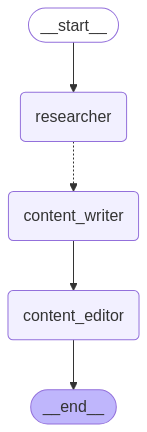

In [15]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

### Testing the Enhanced Workflow

Now let's test the new crew of agents by asking for travel advice for Hoenderloo. Feel free to test with your location of choice.

**Expected Output:**
With the search tool enabled, you should now see much more accurate and detailed information about Hoenderloo, as the researcher agent can search the web for current and factual information rather than relying solely on the model's internal knowledge.

In [21]:
for s in graph.stream({"messages": [("user", "Write a listicle for Hoenderloo, Netherlands.")]}):
    # Get the first key (in this case 'researcher')
    agent_name = list(s.keys())[0]

    print("=" * 50)
    print(f"Agent: {agent_name}")
    print("=" * 50)

    # Print each message in a clean format
    for i, msg in enumerate(s[agent_name]['messages']):
        # Determine if it's a human or AI message
        msg_type = "Human" if "HumanMessage" in str(type(msg)) else "AI"
        print(f"\nMessage #{i+1} - {msg_type}:")
        print(f"Content: {msg.content}")
        
        # Show token usage for AI messages if available
        if hasattr(msg, 'usage_metadata') and msg.usage_metadata:
            print(f"Tokens used: {msg.usage_metadata['total_tokens']}")
        
        print("-" * 30)

    print("\n" + "=" * 50)
    print("----")

Agent: researcher

Message #1 - Human:
Content: Write a listicle for Hoenderloo, Netherlands.
------------------------------

Message #2 - AI:
Content:  1. **Hoge Veluwe National Park**
   - This is a beautiful nature reserve that spans over 5,400 hectares, featuring diverse landscapes such as sand dunes, heathlands, and forests.
   - It's worth visiting for its rich wildlife, picturesque sceneries, and the Kröller-Müller Museum located within the park, which houses the second-largest Van Gogh collection in the world.

2. **Kröller-Müller Museum**
   - As mentioned above, this museum is situated within the Hoge Veluwe National Park and is home to an impressive collection of 19th and 20th-century art.
   - Apart from the extensive Van Gogh collection, the museum also features works by other renowned artists like Claude Monet, Pablo Picasso, and Piet Mondrian, making it a must-visit for art enthusiasts.

3. **Landgoed Staverden**
   - This historic estate and museum offer a glimpse into 

---

## Summary

In this notebook, you've learned how to:

1. Create a sequential multi-agent workflow using LangGraph
2. Define specialized agents with different roles and responsibilities
3. Connect agents in a workflow using StateGraph
4. Enhance agent capabilities by integrating external tools
5. Test the workflow with both well-known and obscure locations

This pattern of sequential agent collaboration can be applied to many other use cases beyond travel content creation, such as customer support, content moderation, data analysis, and more.